### Notebook for testing model functions with input data and examining output

To do:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* See notes in Word doc on the sediment equations, together with a to do list specifically relating to suspended sediment
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters? Can't re-calculate using v=Q/A, as it becomes circular when you try to work out T and V. Other options to reduce the number of parameters?

In [25]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [26]:
# Unit conversions
def UC_Q(Q_mmd, A_catch):
    """Convert discharge from units of mm/day to m3/day"""
    Q_m3d = Q_mmd*1000*A_catch
    return Q_m3d

def UC_Qinv(Q_m3s, A_catch):
    """Convert discharge from units of m3/s to mm/day"""
    Q_mmd = Q_m3s * 86400/(1000*A_catch)
    return Q_mmd

def UC_C(C_kgmm, A_catch):
    """Convert concentration from units of kg/mm to mg/l
    Divide answer by 10**6 to convert from mg/mm to mg/l"""
    C_mgl = C_kgmm/A_catch
    return C_mgl

def UC_Cinv(C_mgl, A_catch):
    """Convert concentration from units of mg/l to kg/mm"""
    C_kgmm = C_mgl*A_catch
    return C_kgmm
    
def UC_V(V_mm, A_catch, outUnits):
    """Convert volume from mm to m^3 or to litres. outUnits 'm3' or 'l'"""
    factorDict = {'m3':10**3, 'l':10**6}
    V = V_mm * factorDict[outUnits] * A_catch
    return V

In [27]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculate for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [28]:
def P_model_1(met_df, p, p_LU, dynamic_dict, run_mode, step_len=1):
    """
    First version of hydrology, sediment and phosphorus model
    Inputs:
        met_df         Dataframe containing columns 'P', the precipitation+snowmelt input to
                       the soil box, and 'PET' (units mm)

        params         Series of parameter values (index = param name)

        dynamic_dict   Dictionary of options controlling whether inputs/variables are calculated
                       dynamically or kept constant.
                       Dictionary keys: 'Dynamic_EPC0', 'Dynamic_effluent_inputs',
                       'Dynamic_terrestrialP_inputs', 'Dynamic_GW_TDP'. Set to 'y' or 'n'.
                       **NB only the first is implemented in the model at the moment***

        run_mode       'cal' or 'val'. Determines whether the soil sorption coefficient, Kf,
                       is calculated (calibration period) or read in as a parameter (validation period)

        step_len       Length of each step in the input dataset (days). Default=1

    Returns a two-element tuple (df, Kf):
    1) A dataframe with column headings:
        Vs: Soil water volume (mm), Qs: Soil water flow (mm/d)
        Vg: Groundwater volume (mm), Qg: Groundwater flow (mm/d)
        Qq: Quick flow (mm/d)
        Vr: Reach volume (mm), Qr: Reach discharge (mm/d), Dr: Daily average reach discharge (mm/d)
        Mland: Sediment mass delivered ot the stream (kg/d), Msus: Reach suspended sediment mass
        P_labile: labile soil P mass (kg), EPC0_kgmm: Soil EPC0 (kg/mm), TDPs: Soil water TDP mass (kg)
        TDPr: Instream TDP mass (kg), PPr: Instream PP mass (kg)
    2) Kf, the soil adsorption coefficient (units mm/kg Soil). #Units (mgP/kgSoil)(mm/kgP).
       Multiply by: 10^-6 for (mm/kgSoil), by A_catch*10^6 for (l/kgSoil)
    """
    
    # #########################################################################################
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """
        Define ODE system
        Inputs:
            y: list of variables expressed as dy/dx. The value of y is determined for the end of the time step
            t: array of time points of interest
            params: tuple of input values & model parameter values
        """
        
        # Unpack initial conditions for this time step 
        # Hydrology
        VsA_i = y[0] # Agricultural soil water volume (mm)
        QsA_i = y[1] # Agricultural soil water flow (mm/day)
        VsS_i = y[2] # Semi-natural soil water volume (mm)
        QsS_i = y[3] # Semi-natural soil water flow (mm/day)
        Vg_i = y[4]  # Groundwater volume (mm)
        Qg_i = y[5]  # Groundwater discharge (mm/day)
        Vr_i = y[6]  # Reach volume (mm)
        Qr_i = y[7]  # Reach discharge (mm/day)
        #(Dr_i would be y[i] here, but it's 0 at the start of every time step)
        # Sediment
        Msus_i = y[9]  # Mass of suspended sediment in the stream reach (kg)
        # Phosphorus
        Plab_i = y[10] # Mass of labile P in the soil (kg)
        TDPs_i = y[11] # Mass of total dissolved P in soil water (kg)
        TDPr_i = y[12] # Mass of total dissolved P in stream reach (kg)
        PPr_i = y[13]  # Mass of particulate P in stream reach (kg)
        
        # Unpack params. Params that vary by LU are series, with indices ['A','S','IG']
        (P, E, Qq_i, Mland_i, f_A, f_S, f_IExcess, alpha, beta, T_s,
        T_g, fc, L_reach, S_reach, A_catch, a_Q, b_Q, E_Q, k_EQ,
        P_netInput, EPC0, Kf, Msoil, TDPeff, TDPg, E_PP, PPeff, P_inactive) = ode_params
    
        # Soil hydrology equations (units mm or mm/day)
        
        # Agricultural land
        dQsA_dV = (((VsA_i - fc)*np.exp(fc - VsA_i))/(T_s['A']*((np.exp(fc-VsA_i) + 1)**2)))
        +(1/(T_s['A']*(np.exp(fc-VsA_i) + 1)))
        dVsA_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsA_i)) - QsA_i
        dQsA_dt = dQsA_dV*dVsA_dt
        
        # Semi-natural/other land
        dQsS_dV = (((VsS_i - fc)*np.exp(fc - VsS_i))/(T_s['S']*((np.exp(fc-VsS_i) + 1)**2)))
        +(1/(T_s['S']*(np.exp(fc-VsS_i) + 1)))
        dVsS_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsS_i)) - QsS_i
        dQsS_dt = dQsS_dV*dVsS_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i)/T_g
        dVg_dt = beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i
        
        # Instream equations (units mm or mm/day)
        dQr_dt = (((Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i) - Qr_i)
                  *a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*(L_reach*1000))) #U/L=1/T. Units (m/s)(s/d)(mm/m)/m(mm/m) 
        dVr_dt = (Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i) - Qr_i
        dDr_dt = Qr_i
        
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = (Mland_i # Delivery from the land (kg/day)
                   + E_Q*S_reach*(Qr_i**k_EQ)  # Entrainment from the stream bed (kg/d)
                   - (Msus_i/Vr_i)*Qr_i) # Outflow from the reach;(kg/mm)*(mm/day)
        
        # Soil labile phosphorus mass (kg) (two alternative formulations; give same results)
        dPlab_dt = Kf*Msoil*((TDPs_i/VsA_i)-EPC0)  # Net sorption
#         dPlab_dt = (Plab_i/EPC0)*((TDPs_i/VsA_i)-EPC0)
        
        # Change in dissolved P mass in soil water (kg/day)
        dTDPs_dt = ((P_netInput*100*A_catch/365)     # Net inputs (fert + manure - uptake) (kg/ha/yr)
                    -(Plab_i/EPC0)*((TDPs_i/VsA_i)-EPC0)#(Kf*Msoil*((TDPs_i/Vs_i)-EPC0)) # Net sorption (kg/day)
                   - (QsA_i*TDPs_i/VsA_i)              # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPs_i/VsA_i))             # Outflow via quick flow (kg/day)
        
        # Change in in-stream TDP mass (kg/d)
        dTDPr_dt = ((1-beta)*QsA_i*(TDPs_i/VsA_i)  # Soil water input. Units: (mm/d)(kg/mm)
                   + Qq_i*(TDPs_i/VsA_i)          # Quick flow input. Units: (mm/d)(kg/mm)
                   + Qg_i*UC_Cinv(TDPg,A_catch)  # Groundwater input. Units: (mm/d)(kg/mm)
                   + TDPeff                      # Effluent input (kg/day)
                   - Qr_i*(TDPr_i/Vr_i))         # Outflow from the reach. Units: (mm/d)(kg/mm)
        
        # Change in in-stream PP mass (kg/d)
        dPPr_dt = (E_PP*Mland_i*(Plab_i+P_inactive)/Msoil  # Delivery from the land
                   + (E_Q*S_reach*(Qr_i**k_EQ))*E_PP*(Plab_i+P_inactive)/Msoil  # M_ent*P content of sed
                   + PPeff                      # Effluent input (kg/day)
                   - Qr_i*(PPr_i/Vr_i))  # Outflow from reach. Units: (mm/d)(kg/mm)
        
        # Add results of equations to an array
        res = np.array([dVsA_dt, dQsA_dt, dVsS_dt, dQsS_dt,dVg_dt, dQg_dt, dVr_dt, dQr_dt, dDr_dt, dMsus_dt,
                       dPlab_dt, dTDPs_dt, dTDPr_dt, dPPr_dt])
        
        return res
    
    # ###########################################################################################
    # --------------------------------------------------------------------------------------------

    # INITIAL CONDITIONS AND DERIVED PARAMETERS
    # Unpack user-supplied initial conditions and calculate other initial conditions which are not modified
    # during looping over met data
    
    # General
    p['f_A'] = p['f_IG']+p['f_Ar'] # Area of intensive agricultural land (as a fraction of total area)
    
    # 1) Hydrology
    VsA0 = p['fc']   # Initial soil volume (mm). Assume it's at field capacity.
    VsS0 = VsA0      # Initial soil vol, semi-natural land (mm). Assume same as agricultural for now!!
    Qg0 = p['Qg0_init']      # Initial groundwater flow (mm/d)
    Qr0 = UC_Qinv(p['Qr0_init'], p['A_catch'])  # Convert units of initial reach Q from m3/s to mm/day
    
    # 2) Initial instream suspended sediment mass (kg). Assume it's 0 kg
    Msus0 = 0.0
    
    # 3) Terrestrial P
    # Calculate initial conditions and convert input param units where necessary
    p['Msoil'] = p['Msoil_m2'] * 10**6 * p['A_catch'] # Soil mass (kg). Units: kgSoil/m2 * m2/km2 * km2
    # Inactive soil P mass (kg). Assume equals semi-natural total soil P mass for all LU classes
    p['P_inactive'] = 10**-6*p_LU['S']['SoilPconc']*p['Msoil']
    
    # Varying by LU (intensive agricultural or semi-natural)
    for LU in ['A','S']:
        # Convert units of EPC0 from mg/l to kg/mm to give initial EPC0
        p_LU.ix['EPC0_0',LU] = UC_Cinv(p_LU[LU]['EPC0_init_mgl'], p['A_catch'])
        # Initial labile P. Units: kgP/mgP * mgP/kgSoil * kgSoil. Assume Plab0 = 0 for semi-natural
        p_LU.ix['Plab0',LU] = 10**-6*(p_LU[LU]['SoilPconc']-p_LU['S']['SoilPconc']) * p['Msoil']  
        # Initial soil water TDP mass (kg); Units: (kg/mm)*mm
        p_LU.ix['TDPs0',LU] = p_LU[LU]['EPC0_0'] * (p['f_A']*VsA0+p['f_S']*VsS0)
    
    Plab0_A, Plab0_S = p_LU.ix['Plab0','A'], p_LU.ix['Plab0','S']
    TDPs0_A, TDPs0_S = p_LU.ix['TDPs0','A'], p_LU.ix['TDPs0','S']
    
    # Set the value for Kf, the adsorption coefficient (mm/kg soil)
    if run_mode == 'cal':
        # If the calibration period, calculate. Assume SN has EPC0=0, PlabConc =0
        Kf = 10**-6*(p_LU['A']['SoilPconc']-p_LU['S']['SoilPconc'])/p_LU['A']['EPC0_0']  # (kg/mg)(mg/kgSoil)(mm/kg)
    else:
        # If not the calibration period, read Kf in from the series of param values
        Kf = p['Kf']

    # 4) Initial instream TDP and PP masses (kg; assume both equal 0.0)
    TDPr0 = 0.0
    PPr0 = 0.0
    
    # --------------------------------------------------------------------------------------------    
    # SETUP ADMIN FOR LOOPING OVER TIME STEPS
    # Time points to evaluate ODEs at (we're only interested in the start and end of each step)
    ti = [0, step_len]
    # Lists to store output
    output_ODEs = []  # From ode_f function
    output_nonODE = []  # Will include: Qq, Mland

    # --------------------------------------------------------------------------------------------
    # START LOOP OVER MET DATA
    for idx in range(len(met_df)):

        # Get precipitation and evapotranspiration for this day
        P = met_df.ix[idx, 'P']
        E = met_df.ix[idx, 'PET']
        
        # THESE SHOULD VARY WITH LU!!!
        # Calculate infiltration excess (mm/(day * catchment area))
        Qq_i = p_LU['A']['f_IExcess']*P
        
        # Calculate terrestrial erosion and delivery to the stream, Mland (kg/day)
        Mland_i = p_LU['A']['E_land']*(Qq_i**p['k_Eland']) #Units: (kg/mm)*(mm/day)
        
        # Calculate dynamic EPC0 as a function of labile P mass
        if dynamic_dict['Dynamic_EPC0'] == 'y':
            EPC0_i = p_LU['A']['Plab0']/(Kf*p['Msoil']) # First timestep this equals EPC0_0
        else:
            EPC0_i = p_LU['A']['EPC0_0']
        
        # Append to non ODE results
        output_nonODE_i = [Qq_i, Mland_i, EPC0_i]
        output_nonODE.append(output_nonODE_i)

        # Calculate additional initial conditions from user-input initial conditions/ODE solver output
        QsA0 = (VsA0 - p['fc'])/(p_LU['A']['T_s']*(1 + np.exp(p['fc'] - VsA0))) # Soil flow (mm/d)
        QsS0 = (VsS0 - p['fc'])/(p_LU['S']['T_s']*(1 + np.exp(p['fc'] - VsS0)))
        Vg0 = Qg0 *p['T_g'] # groundwater vol (mm)
        Tr0 = (1000*p['L_reach'])/(p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**7)) #Reach time constant (days); T=L/aQ^b
        Vr0 = Qr0*Tr0 # Reach volume (V=QT) (mm)

        # Vector of initial conditions for start of time step (assume 0 for Dr0, daily mean instream Q)
        y0 = [VsA0, QsA0, VsS0, QsS0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0, Plab0_A,
              TDPs0_A, TDPr0, PPr0]

        # Today's rainfall, ET & model parameters for input to solver
        ode_params = [P, E, Qq_i, Mland_i, p['f_A'], p['f_S'],
                              p_LU['A']['f_IExcess'],p_LU['A']['alpha'], p['beta'],
                              p_LU.ix['T_s'], p['T_g'], p['fc'],
                              p['L_reach'], p['S_reach'], p['A_catch'],
                              p['a_Q'], p['b_Q'],
                              p['E_Q'], p['k_EQ'],
                              p_LU['A']['P_netInput'], EPC0_i, Kf, p['Msoil'],
                              p['TDPeff'], p['TDPg'],
                              p['E_PP'], p['PPeff'], p['P_inactive']]

        # Solve ODEs
        y = odeint(ode_f, y0, ti, args=(ode_params,))

        # Extract values for the end of the step
        res = y[1]
        res[res<0] = 0 # Numerical errors may result in very tiny values <0; set these back to 0
        output_ODEs.append(res)

        # Update initial conditions for next step (for Vs, Qg0, Qr0, Msus0, Plab0, TDPs0)
        VsA0 = res[0]
        VsS0 = res[2]
        # FUDGE to re-set groundwater to user-supplied min flow at start of each time step!!!
        if p['Qg_min'] > res[5]:
            Qg0 = p['Qg_min']
        else:
            Qg0 = res[5]
        Qr0 = res[7]
        Msus0 = res[9]
        Plab0_A = res[10]
        TDPs0_A = res[11]
        TDPr0 = res[12]
        PPr0 = res[13]
        
        # END LOOP OVER MET DATA
    # --------------------------------------------------------------------------------------------
    
    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['VsA', 'QsA','VsS', 'QsS','Vg', 'Qg', 'Vr', 'Qr', 'Dr',
                               'Msus', 'P_labile','TDPs', 'TDPr', 'PPr'],
                      index=met_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_nonODE), columns=['Qq', 'Mland', 'EPC0_kgmm'],
                      index=met_df.index)

    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)

    return (df, Kf)

In [29]:
# USER INPUT

# Input file paths
metdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\Tar_AvMetData_1981-2010.csv'
Qobsdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.csv'
chemObsData_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.csv'
params_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\parameters.xlsx'

# Simulation period
st_dt = '2004-01-01'  # Start date
end_dt = '2005-07-31' # End date

# Include snow melt and accumulation module?
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Sewage input; calculate input as kg TDP/day, if desired, from Q (m3/s) and TDP (mg/l)
Q_eff = 0.001 # m3/s
TDPeff_conc = 3.0 # mg/l
TDPeff = Q_eff*TDPeff_conc*86400*1000*10**-6  # Units: (m3/s)(mg/l)(s/d)(l/m3)(kg/mg)

# Model parameters, including starting guesses for those being calibrated
# Units: L_reach in mm for now. a_Q and b_Q are for m/s vs m3/s, therefore convert in script for now.
param_dict = {'A_catch': 51.7, 'f_IG':0.3, 'f_Ar':0.2, 'f_S':0.5, 'L_reach':10000. , 'S_reach':0.8,
              'fc':290.,'alpha':0.95, 'beta':0.6,'f_IExcess':0.015, 'T_s':3.,'T_g':60., 'Qg_min':0.4,
              'a_Q':0.5, 'b_Q':0.5,'Qg0_init':1.0, 'Qr0_init': 1.0,
              'E_land':5000., 'k_Eland':1.2, 'E_Q': 300., 'k_EQ':1.7,
              'P_netInput': 5.0, 'EPC0_init_mgl':0.07, 'Kf': 5.5263885e-05,
              'TDPeff':TDPeff, 'TDPg':0.01,
              'PPeff': 0.1*TDPeff/0.9, 'E_PP':2.0,
              'SoilPconc_SN':900., 'SoilPconc_A':1100., 'Msoil_m2':200.}
            # A_catch: catchment area (km2) Coull: 51.7; Aboyne: 73.7; L_reach: reach length (m)
            # E_land: Erodibility (kg/mm)
            # E_Q: Instream entrainment factor (kg/mm)
            # k_Eland, k_EQ: non-linear coefficients for sed delivery, entrainment
            # Qg0_init: Initial groundwater flow (mm/day)
            # Qr0_init: Initial in-stream flow (m3/s) (keep constant)
            # PPeff: Effluent PP input (kg P/day). E.g. 'PPeff': 0.1*TDPeff/0.9

# Model options for whether variables/inputs are dynamic or constant. 'y' or 'n'.
dynamic_dict = {'Dynamic_EPC0':'n', 'Dynamic_effluent_inputs': 'n',
                'Dynamic_terrestrialP_inputs': 'n', 'Dynamic_GW_TDP': 'n'}

In [30]:
# READ IN INPUT DATA
# Met data and observations
met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
Qobs_df = pd.read_csv(Qobsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
chemObs_df = pd.read_csv(chemObsData_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Read in model parameters from file
# Land use parameters
p_LU = pd.read_excel(params_fpath, sheetname='LU',index_col=0,parse_cols="B,E,F,G")      # Values in cols 'A','S','IG'
# Sub-catchment and reach parameters
p_SC_R = pd.read_excel(params_fpath, sheetname='SC_reach',index_col=0, parse_cols="B,E") # Values in cols '1', '2',..
# Parameters that're constant over land use, sub-catchment or reach
p_constant_df = pd.read_excel(params_fpath, sheetname='Constant',index_col=0,
                           parse_cols="B,E")                                             # Values in col 'Value'
p_constant = p_constant_df['Value'] #convert to a series

In [31]:
# PROCESS INPUT DATA & SET UP

# Truncate the met and observed data to the desired period
met_df = met_df.truncate(before=st_dt, after=end_dt)
Qobs_df = Qobs_df.truncate(before=st_dt, after=end_dt)
chemObs_df = chemObs_df.truncate(before=st_dt, after=end_dt)
# Combine Q and chem data into one df
obs_df = pd.concat([Qobs_df, chemObs_df], axis=1)

# Store parameter values in series, referenced by their names (the row indices)
# p = pd.Series(param_dict)  # All params; cols = param names, one row with values

# p = pd.concat([p_LU['A'],p_SC_R[1],p_constant['Value']])
p = pd.concat([p_SC_R[1],p_constant],axis=0)

In [32]:
# RUN MODEL

# If desired, run snow module
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

# Run model. If calibrating, Kf parameter is calculated and output to parameter series
df, p['Kf'] = P_model_1(met_df=met_df, p=p, p_LU=p_LU, dynamic_dict=dynamic_dict, run_mode='cal')

In [33]:
# POST-PROCESSING OF MODEL OUTPUT

# Calculate simulated concentrations and add to results
df['Msus_mgl'] = UC_C(df['Msus']/df['Vr'],p['A_catch'])
# df['TDPs_mgl'] = UC_C(df['TDPs']/df['Vs'], p['A_catch'])
df['EPC0_mgl'] = UC_C(df['EPC0_kgmm'], p['A_catch'])
df['Plabile_mg/kg'] = 10**6*df['P_labile']/(p['Msoil_m2'] * 10**6 * p['A_catch'])
df['TDPr_mgl'] = UC_C(df['TDPr']/df['Vr'], p['A_catch'])
df['PPr_mgl'] = UC_C(df['PPr']/df['Vr'], p['A_catch'])
df['TPr_mgl'] = df['TDPr_mgl']+df['PPr_mgl']

# Convert some volume and flow units
df['Sim_Q_cumecs'] = df['Dr']*p['A_catch']*1000/86400
df['Sim_Vr_l'] = df['Vr']*p['A_catch']*10**6

# Add snow depth and observed data to model results df
df['D_snow'] = met_df['D_snow_end']
df = pd.concat([df, obs_df], axis=1)

TDP NSE: -25.9647262779
TDP NSE on logs -8.80929517489
TDP Spearman's rank CC: 0.391037287056
TDP R2: 0.206254647579
TP NSE: -2.14396105251
TP NSE on logs -2.99491338511
TP Spearman's rank CC: 0.328812780668
TP R2: 0.12814008157


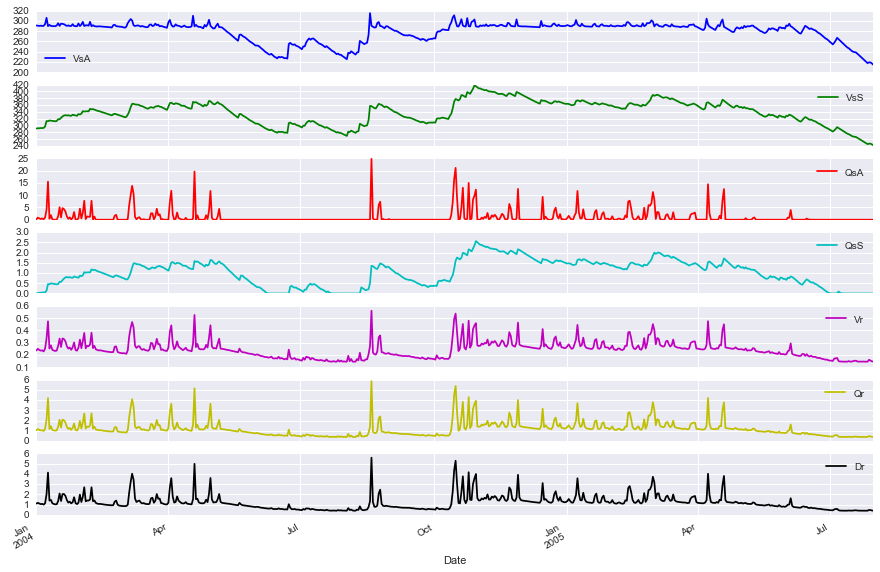

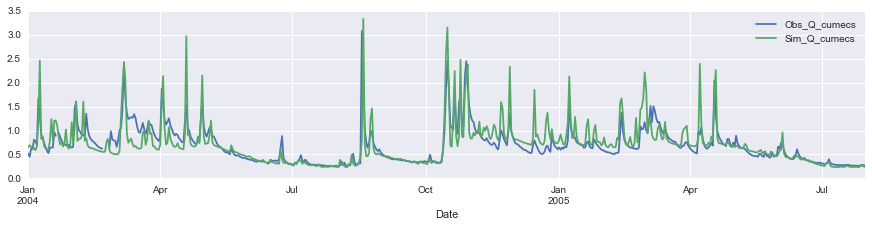

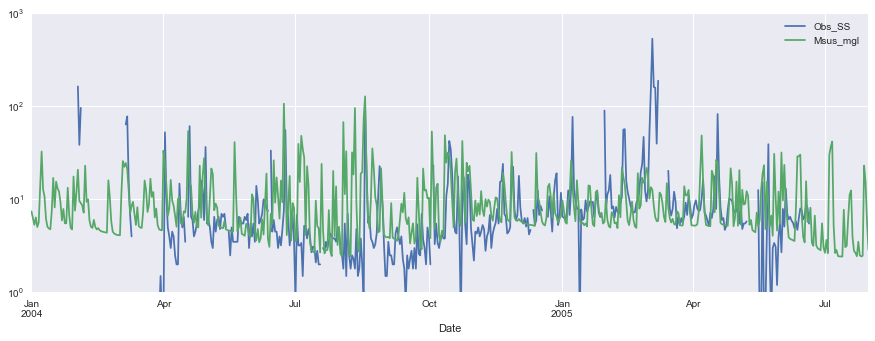

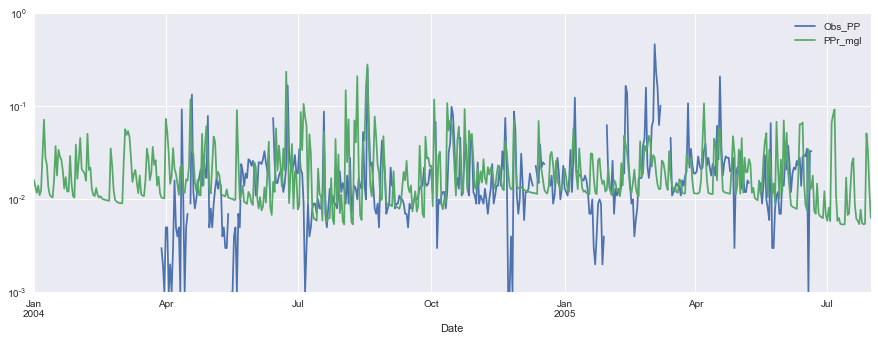

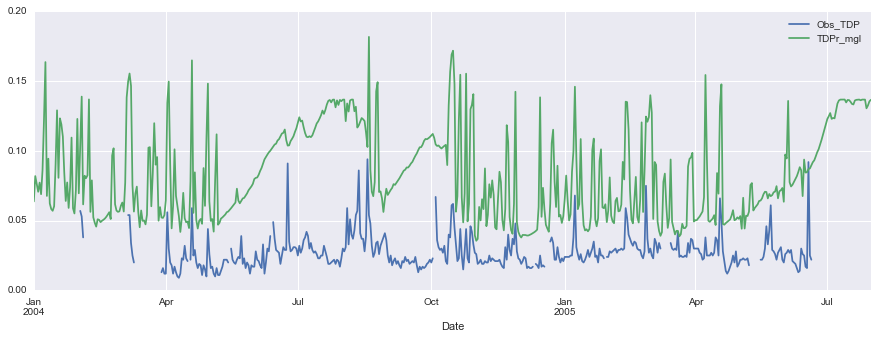

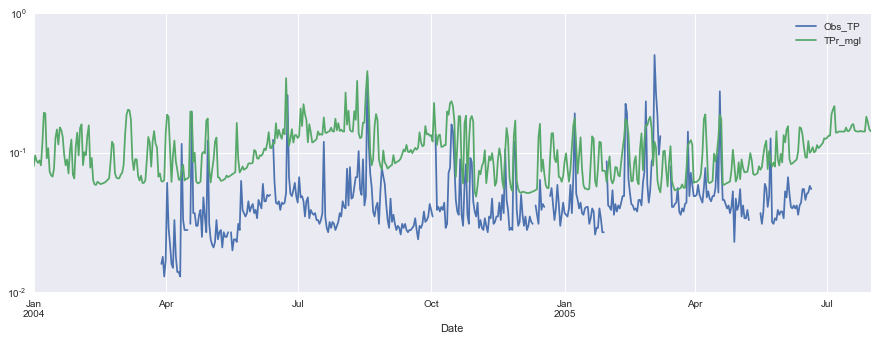

In [34]:
# EXAMINE OUTPUT

# Plot some timeseries

# Internal stuff
fig3 = df[['VsA','VsS','QsA','QsS','Vr','Qr','Dr']].plot(subplots=True,figsize=(15, 10))
# fig3 = df[['Plabile_mg/kg','EPC0_mgl','TDPs_mgl']].plot(subplots=True,figsize=(15, 10))
# fig3 = df[['Qq','Dr','Vr','Mland', 'Msus', 'Msus_mg-l']].plot(subplots=True,figsize=(15, 15))

# Discharge
fig1 = df[['Obs_Q_cumecs', 'Sim_Q_cumecs']].plot(figsize=(15, 3))
# df_logs = np.log(df)
# fig2 = df_logs[['Sim_Q_cumecs', 'Obs_Q_cumecs']].plot(alpha=0.5,figsize=(15, 3))

# Observed & simulated SS conc
fig4 = df[['Obs_SS', 'Msus_mgl']].plot(figsize=(15,5),logy=True)
fig4.set_ylim(1)
# plt.savefig(r'M:\Working\NewModel\ModelOutputs\sed1.png')

# Observed & simulated instream PP conc
fig6 = df[['Obs_PP', 'PPr_mgl']].plot(figsize=(15,5),logy=True)

# Observed & simulated instream TDP conc
fig5 = df[['Obs_TDP', 'TDPr_mgl']].plot(figsize=(15,5),logy=False)

# Observed & simulated instream TP conc
fig7 = df[['Obs_TP', 'TPr_mgl']].plot(figsize=(15,5),logy=True)

# Print some stats
key_dict = {('Q','obs'):'Obs_Q_cumecs', ('Q','sim'):'Sim_Q_cumecs',
            ('SS','obs'):'Obs_SS', ('SS','sim'):'Msus_mgl',
            ('TDP','obs'):'Obs_TDP', ('TDP','sim'):'TDPr_mgl',
            ('PP','obs'):'Obs_PP', ('PP','sim'):'PPr_mgl',
            ('TP','obs'):'Obs_TP', ('TP','sim'):'TPr_mgl'}
for var in ['TDP','TP']:
    obs = df[key_dict[(var,'obs')]]
    sim = df[key_dict[(var,'sim')]]
    temp_df = pd.concat([obs,sim],axis=1)
    log_obs = np.log(obs)
    log_sim = np.log(sim)

    NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
    log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))
    spearmans_r = temp_df.corr(method='spearman')
    r2 = (temp_df.corr(method='pearson'))**2
    print "%s NSE:" %var, NSE
    print "%s NSE on logs" %var, log_NSE
    print "%s Spearman's rank CC:" %var, spearmans_r[key_dict[(var,'obs')]].ix[1]
    print "%s R2:" %var, r2[key_dict[(var,'obs')]].ix[1]

In [35]:
df.sort_index(axis=1)
df.head()

,VsA,QsA,VsS,QsS,Vg,Qg,Vr,Qr,Dr,Msus,...,TPr_mgl,Sim_Q_cumecs,Sim_Vr_l,D_snow,Obs_Q_cumecs,Obs_SRP,Obs_SS,Obs_TDP,Obs_TP,Obs_PP
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,291.187108,0.149348,291.240873,0.003217,59.025034,0.983751,0.236125,1.040527,1.095720,90.601415,...,0.080095,0.655657,12207687.260539,0,0.519719,NaN,NaN,NaN,NaN,NaN
2004-01-02,290.867190,0.846092,291.776450,0.021627,58.316095,0.971935,0.249684,1.163457,1.159168,81.488247,...,0.095858,0.693622,12908686.648637,0,0.452732,NaN,NaN,NaN,NaN,NaN
2004-01-03,290.380622,0.542578,291.831553,0.030628,57.531499,0.958858,0.240787,1.082016,1.100844,66.408290,...,0.087873,0.658723,12448689.814310,0,0.623296,NaN,NaN,NaN,NaN,NaN
2004-01-04,290.874715,0.295525,292.550511,0.034407,56.667187,0.944453,0.234900,1.029758,1.035288,77.785014,...,0.084784,0.619495,12144352.729221,0,0.611836,NaN,NaN,NaN,NaN,NaN
2004-01-05,290.252580,0.538008,292.451767,0.046972,55.914304,0.931905,0.237713,1.054561,1.062124,61.999816,...,0.088385,0.635553,12289738.616140,0,0.809897,NaN,NaN,NaN,NaN,NaN


In [36]:
p_LU.ix['T_s'], p['T_g'], p['fc'],
p['L_reach'], p['S_reach'], p['A_catch'],
p['a_Q'], p['b_Q'],
p['E_Q'], p['k_EQ'],
p_LU['A']['P_netInput'], EPC0_i, Kf, p['Msoil'],
p['TDPeff'], p['TDPg'],
p['E_PP'], p['PPeff'], p['P_inactive']])

SyntaxError: invalid syntax (<ipython-input-36-98acb2c2e23c>, line 7)

In [ ]:
p_LU.ix['T_s']